# Zero-Shot-Classification

## Bibliotheken installieren und importieren

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install -q langchain "transformers[sentencepiece]"

In [73]:
import pandas as pd
from tqdm import tqdm

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import DataFrameLoader
from langchain import HuggingFacePipeline
import transformers
from transformers import pipeline

## Daten einlesen und bearbeiten

Die Daten müssen in kleinere Abschnitte unterteilt werden, daa die Kontektlänge der genutzen Modelle sehr begrenzt ist.

In [10]:
df = pd.read_parquet('/content/drive/MyDrive/Masterthesis/2023-06-16_gesamtdaten_bis_2022.parquet')

In [11]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

df['text_split'] = df['text'].apply(lambda x: text_splitter.split_text(x))
df_explode = df.explode('text_split')
df_explode = df[['index_doc', 'datum', 'text_split', 'kommune', 'kommunale_ebene']]
df_explode['text_split_laenge'] = df_explode['text_split'].str.len()
df_explode = df_explode[df_explode['text_split_laenge'] > 0].reset_index()

<ipython-input-11-8540c89958fd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_explode['text_split_laenge'] = df_explode['text_split'].str.len()


## Speichern und Aufbereitung der Daten der ZSC in einer Funktion

In [8]:
def zero_shot_classification(texts: list, labels:list, classifier):
    with classifier.device_placement():
        outputs = classifier(texts, candidate_labels, multi_label=True)

    preds = []
    #loop for each text in text_list
    for input_sequence in tqdm(outputs, total=len(outputs)):
        label_scores = dict(zip(input_sequence['labels'], input_sequence['scores']))
        preds.append(label_scores)
    #store the labels probabilities in a df
    preds_df = pd.DataFrame(preds)
    preds_df = preds_df.add_prefix("zsc_")

    return(preds_df)

In [13]:
candidate_labels = ['Verkehr', 'Elektromobilität', 'Automobil', 'Parken', 'Fahrrad', 'Öffentlicher Verkehr', 'Bus', 'Bahn',
                    'zu Fuß gehen', 'Carsharing', 'Bikesharing', 'E-Scooter']

## Zero-Shot-Classification mit MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7

In [6]:
# Nur mit der transformers Bibliothek nutzen

# classifier_deberta = pipeline("zero-shot-classification",
#                       model="MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7",
#                      device=0
#                       )

# df_zsc = zero_shot_classification(df_explode['text_split'].tolist(), labels=candidate_labels, classifier=classifier_deberta)
# df_explode = df_explode.join(df_zsc)
# df_explode.to_parquet("/content/drive/MyDrive/Masterthesis/2023-06-17_gesamt_zsc_mDeBERTa-v3.parquet")

## Zero-Shot-Classification mit vicgalle/xlm-roberta-large-xnli-anli

In [4]:
# Mit der "transformers[sentencepiece]" Bibliothek nutzen

classifier_roberta = pipeline("zero-shot-classification",
                              model="vicgalle/xlm-roberta-large-xnli-anli",
                              device=0
                              )

In [ ]:
df_zsc = zero_shot_classification(df_explode['text_split'].tolist(), labels=candidate_labels, classifier=classifier_roberta)

100%|██████████| 68663/68663 [00:00<00:00, 437492.59it/s]


In [ ]:
df_explode = df_explode.join(df_zsc)
df_explode.to_parquet("/content/drive/MyDrive/Masterthesis/2023-06-17_gesamt_zsc_roberta.parquet")

## Ergebnisse

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import re
from tqdm import tqdm

%matplotlib inline
tqdm.pandas()

In [15]:
df_deberta = pd.read_parquet("data/zero-shot-classification/2023-06-17_gesamt_zsc_mDeBERTa-v3.parquet")

In [16]:
df_deberta = df_deberta.set_index('index_doc')

In [17]:
df_deberta.loc[1839, 'text_split']

array(['Stadt Bad Friedrichshall Blatt  1 NIEDERSCHRIFT über die Verhandlung des Gemeinderate s  am 07.06.2011  Anwesend: Der Bürgermeister und 25 Stadträte  Entschuldigt: StR Zahn  Außerdem anwesend: StVD Friede, StBM Loose, StAR Fe ldmeyer, FBLin Herrmann, StAR Graf,  zugleich als Protokollführer  Dauer der Sitzung: 18:00 - 21:00 Uhr  öffentlich  Vorsitzender:  Mitglieder des Gemeinderates:  Protokollführer:'],
      dtype=object)

In [18]:
df_deberta["jahr"] = df_deberta['datum'].dt.strftime('%Y')

In [19]:
candidate_labels = ['Verkehr', 'Elektromobilität', 'Automobil', 'Parken', 'Fahrrad', 'Öffentlicher Verkehr', 'Bus', 'Bahn',
                    'zu Fuß gehen', 'Carsharing', 'Bikesharing', 'E-Scooter']
labels_prefix = [f"zsc_{item}" for item in candidate_labels]

In [20]:
def score_threshold(score):
    if score < 0.6:
        return False
    else:
        return True

In [21]:
# Funktion score_threshold auf Datensatz anwenden
df_deberta_bool = df_deberta[labels_prefix].progress_applymap(lambda x: score_threshold(x))

100%|██████████████████████████████████████████████████████████████████████| 823956/823956 [00:01<00:00, 627101.85it/s]


In [22]:
df_deberta[candidate_labels] = df_deberta_bool[labels_prefix]

In [23]:
# Dokumentenabschnitte aggregieren
df_deberta_doc = df_deberta.groupby(['index_doc', 'datum','kommune', 'jahr'], as_index=False).agg({key: 'any' for key in candidate_labels})

In [24]:
# Attribute aggregieren: Wenn True, dann wurde ein verkehrliches Thema behandelt
df_deberta_doc['Gesamt_bool'] = [any(row) for row in df_deberta_doc[candidate_labels].to_numpy()]

# Attribute ÖV und Neue Mobilität aggregieren
df_deberta_doc['ÖV'] = [any(row) for row in df_deberta_doc[['Bus', 'Bahn', 'Öffentlicher Verkehr']].to_numpy()]
df_deberta_doc['Neue Mobilität'] = [any(row) for row in df_deberta_doc[['Carsharing', 'Bikesharing', "E-Scooter"]].to_numpy()]

In [26]:
verkehr_labels = ['Allgemein', 'MIV', 'E-Mobilität', 'Parken', 'Fahrrad', 'Gehen', 'ÖV', 'Neue Mobilität']

In [30]:
stichwortgruppen = ['Verkehr', 'Automobil', "Elektromobilität", 'Parken', 'Fahrrad', 'zu Fuß gehen', 
                    'ÖV', 'Neue Mobilität']

In [28]:
rename_labels = {}
for old, new in zip(stichwortgruppen, verkehr_labels):
    rename_labels[old] = new

In [31]:
temp = stichwortgruppen + ['kommune', 'jahr']
df_deberta_slim_count = df_deberta_doc[temp].groupby(['jahr', 'kommune'], as_index=False).sum()

In [32]:
df_deberta_slim_count.rename(columns=rename_labels, inplace=True)

## Ergebnisse

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from my_plot import set_size

%matplotlib inline
width = 'thesis'

### Nach Dokumenten

In [34]:
kommunen_order = ['Bad Dürkheim', 'Bad Friedrichshall', 'Bad Rappenau', 'Bensheim',
       'Frankenthal', 'Hassloch', 'Heppenheim', 'Hockenheim', 'Homburg',
       'Lampertheim', 'Landau', 'Leimen', 'Pirmasens', 'Schwetzingen',
       'Schifferstadt', 'Speyer', 'Viernheim', 'Weinheim', 'Wiesloch',
       'Wörth am Rhein', 'Kreis Bad Dürkheim', 'Kreis Bergstraße',
       'Kreis Germersheim', 'Kreis Heilbronn', 'Rhein-Neckar-Kreis',
       'Rhein-Pfalz-Kreis', 'Saarpfalz-Kreis']
kommunen_label = ['Bad Dürkheim', 'Bad Friedrichshall', 'Bad Rappenau', 'Bensheim',
       'Frankenthal', 'Hassloch', 'Heppenheim', 'Hockenheim', 'Homburg',
       'Lampertheim', 'Landau', 'Leimen', 'Pirmasens', 'Schwetzingen',
       'Schifferstadt', 'Speyer', 'Viernheim', 'Weinheim', 'Wiesloch',
       'Wörth am Rhein', 'Kreis Bad Dürkheim', 'Kreis Bergstraße',
       'Kreis Germersheim', 'Kreis Heilbronn', 'Rhein-Neckar-Kreis',
       'Rhein-Pfalz-Kreis', 'Saarpfalz-Kreis']

In [35]:
stichwortgruppen = verkehr_labels

In [36]:
# Anzahl der Dokumente pro Kommune zusammenfassen
temp = verkehr_labels + ['kommune']
df_deberta_doc_kommune = df_deberta_slim_count[temp].groupby(['kommune']).sum()

df_kommune_gesamt_transpone_count = df_deberta_doc_kommune.T

df_kommune_gesamt_transpone_count_percent = (df_kommune_gesamt_transpone_count / df_kommune_gesamt_transpone_count.sum()) * 100

df_kommune_gesamt_count_percent = df_kommune_gesamt_transpone_count_percent.T
df_kommune_gesamt_count_percent.reset_index(inplace=True)

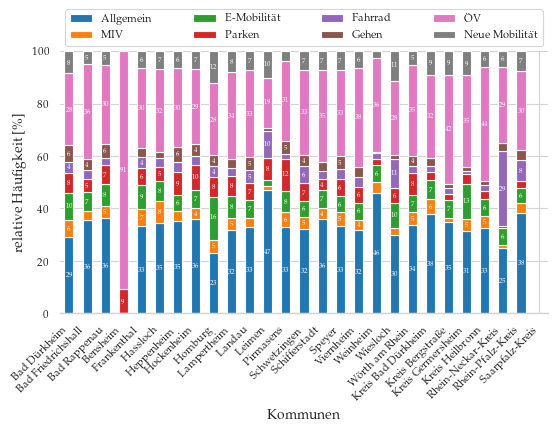

In [70]:
ax = df_kommune_gesamt_count_percent.set_index('kommune').loc[kommunen_order].plot(kind = 'bar', stacked = True, figsize=(6.299212813062128, 3.4))

# sns.set_style('whitegrid')

plt.xlabel ("Kommunen")
plt.ylabel ("relative Häufigkeit [\%]")
# fig.autofmt_xdate(rotation=45)
ax.set_xticklabels(kommunen_label, rotation = 45, ha='right')
# plt.legend(ncol=3)

sns.despine(left=True)
ax.set(ylim=(0, 100))


for i, rect in enumerate(ax.patches):
    # Find where everything is located
    height = rect.get_height()
    width_x = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # The height of the bar is the count value and can used as the label
    label_text = f'{height:.0f}'

    label_x = x + width_x / 2
    label_y = y + height / 2

    # don't include label if it's equivalently 0
    if height > 4:
        ax.text(label_x, label_y, label_text, ha='center', va='center', color='white', fontsize=5)


plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=4)
fig = ax.get_figure()

fig.savefig('../../latex/Figures/plots/zsc_docs_gesamt_relative_haeufigkeit_verkehr.pdf', format='pdf', bbox_inches='tight')

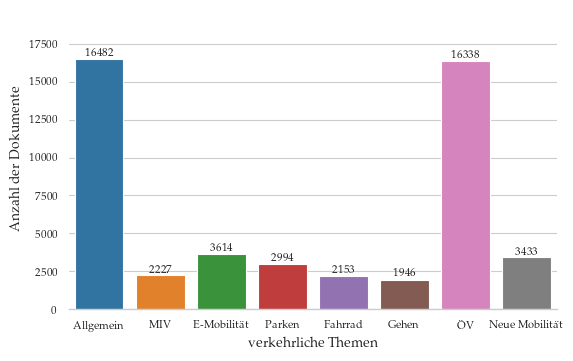

In [69]:
# Sum within all documents
fig, ax = plt.subplots(1, 1, figsize=set_size(width))
plt.style.use('tex.mplstyle')
# sns.set_style('whitegrid')

ax = sns.barplot(df_deberta_doc_kommune.agg(['sum']))
ax.set(xlabel='verkehrliche Themen', ylabel='Anzahl der Dokumente')

sns.despine(left=True)

for c in ax.containers:
    # add custom labels with the labels=labels parameter if needed
    # labels = [f'{h}' if (h := v.get_height()) > 0 else '' for v in c]
    ax.bar_label(c, label_type='edge', fontsize=8)
ax.margins(y=0.2)

fig.savefig('../../latex/Figures/plots/zsc_docs_regex_verkehr.pdf', format='pdf', bbox_inches='tight')

In [39]:
df_total_count_per_year = df_deberta_slim_count.groupby('jahr', as_index=False)[stichwortgruppen].sum()

In [76]:
set_size(width)

(6.299212813062128, 3.893127620841233)

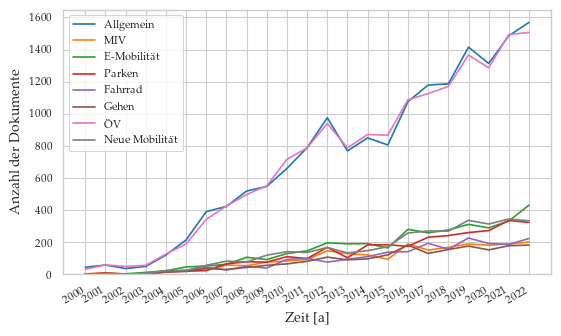

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(6.299212813062128, 3.893127620841233)

)

sns.lineplot(x='jahr' ,y='value', data=pd.melt(df_total_count_per_year, id_vars='jahr'), hue='variable')
ax.set(xlabel='Zeit [a]', ylabel='Anzahl der Dokumente')

ax.set_ylim(bottom=0)
ax.legend_.set_title(None)
fig.autofmt_xdate()
plt.style.use('tex.mplstyle')

fig.savefig('../../latex/Figures/plots/zsc_docs_gesamt_jahr_verkehr.pdf', format='pdf', bbox_inches='tight')

In [52]:
fallbeispiele = ['Frankenthal', 'Schwetzingen', 'Lampertheim', 'Kreis Bergstraße']

In [53]:
temp = ['jahr', 'kommune'] + stichwortgruppen
df_kommune_per_year_count = df_deberta_slim_count[temp].groupby(['jahr','kommune'], as_index=False).sum()

In [56]:
df_bsp_count_per_year = df_kommune_per_year_count[df_kommune_per_year_count['kommune'].isin(fallbeispiele)]

In [54]:
df_kommune_per_year_count['Gesamt']= df_kommune_per_year_count[stichwortgruppen].sum(axis=1)

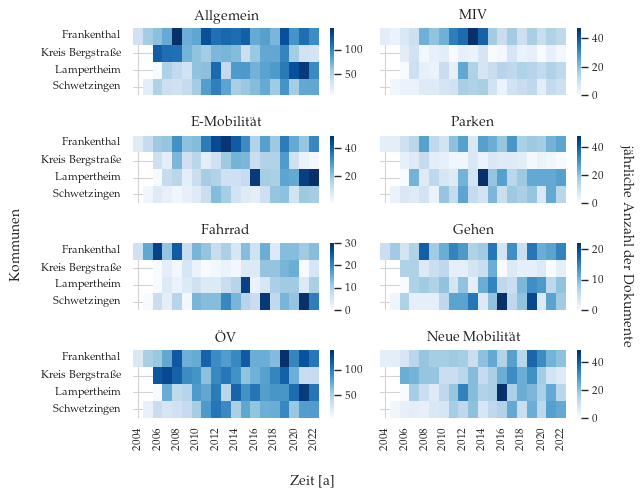

In [71]:
fig, axes = plt.subplots(4, 2, figsize=(6.299212813062128, 5), sharex=True, sharey=True)

for ax, attr in zip(axes.ravel(), stichwortgruppen):
    # filter df for ticker and plot on specified axes
    bsp_heatmap = df_bsp_count_per_year.pivot_table(index='kommune', columns='jahr', values=attr)
    sns.heatmap(data=bsp_heatmap, ax=ax, cmap='Blues')
    ax.set_title(attr, fontsize = 10)
    ax.set(xlabel=None, ylabel=None)

fig.supxlabel('Zeit [a]', fontsize=10)
fig.supylabel('Kommunen', fontsize=10)
fig.text(x=1, y=0.5, s="jährliche Anzahl der Dokumente", size=10, fontweight='bold', rotation=270, ha='center', va='center')

fig.tight_layout()
fig.savefig('../../latex/Figures/plots/zsc_heatmaps_docs_gesamt_jahr_kommunen_vergleich.pdf', format='pdf', bbox_inches='tight')

In [58]:
df_bsp_count_per_year['Gesamt'] = df_bsp_count_per_year[stichwortgruppen].sum(axis=1)

C:\Users\johan\AppData\Local\Temp\ipykernel_29500\2848851046.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bsp_count_per_year['Gesamt'] = df_bsp_count_per_year[stichwortgruppen].sum(axis=1)


In [ ]:
df_bsp_count_per_year

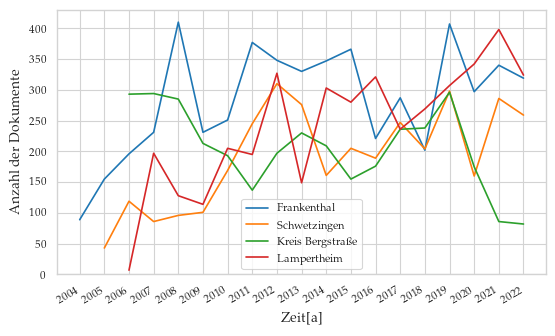

In [59]:
fig, ax = plt.subplots(1, 1, figsize=set_size(width))
plt.style.use('tex.mplstyle')
sns.lineplot(x='jahr' ,y='Gesamt', data=df_bsp_count_per_year, hue='kommune')
fig.autofmt_xdate()
ax.set(xlabel='Zeit[a]', ylabel='Anzahl der Dokumente')
ax.set_ylim(bottom=0)

ax.legend_.set_title(None)

fig.savefig('../../latex/Figures/plots/zsc_docs_gesamt_jahr_kommunen_vergleich.pdf', format='pdf', bbox_inches='tight')

In [63]:
df_bsp_count_per_year['jahr_int'] = df_bsp_count_per_year['jahr'].astype(int)

C:\Users\johan\AppData\Local\Temp\ipykernel_29500\605789991.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bsp_count_per_year['jahr_int'] = df_bsp_count_per_year['jahr'].astype(int)


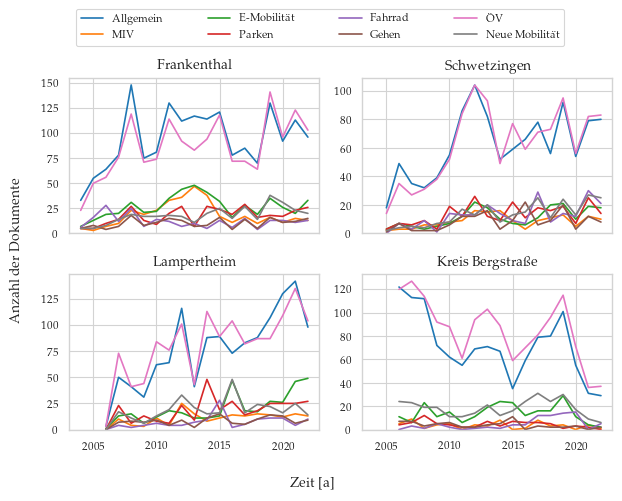

In [64]:
fig, axes = plt.subplots(2, 2, figsize=(6.299212813062128, 4.893127620841233), sharex=True)
temp_list = ['jahr_int'] + stichwortgruppen                  
for fallbeispiel, ax in zip(fallbeispiele, axes.ravel()):
    # filter df for ticker and plot on specified axes
    df_bsp_count_per_year[df_bsp_count_per_year["kommune"] == fallbeispiel][temp_list].plot(x='jahr_int', ax=ax)

    # chart formatting
    ax.set_title(fallbeispiel, fontsize = 10)
    ax.get_legend().remove()
    ax.set(xlabel=None, ylabel=None)
    ax.set_ylim(bottom=0)

bb = (fig.subplotpars.left, fig.subplotpars.top+0.04, 
      fig.subplotpars.right-fig.subplotpars.left,.1)
# fig.autofmt_xdate()
axes[0][0].legend(bbox_to_anchor=bb, mode="expand", loc="lower left",
               ncol=4, borderaxespad=0., bbox_transform=fig.transFigure)
plt.style.use('tex.mplstyle')
fig.supxlabel('Zeit [a]', fontsize=10)
fig.supylabel('Anzahl der Dokumente', fontsize=10)

fig.tight_layout()
fig.savefig('../../latex/Figures/plots/zsc_docs_verkehr_jahr_kommunen_vergleich.pdf', format='pdf', bbox_inches='tight')

In [ ]:
fig = px.bar(df_deberta_doc_kommune, 
             # color=df_kommune_gesamt.index,
              # line_group='kommunale_ebene',''
              # hover_name="kommune",
              labels={
                     "jahr": "Zeit (a)",
                     "Gesamt": "Häufigkeit aller Stichwörter",
                     "kommune": "Kommunen",
                     "variable": "Stichwortgruppen",
                     "value": "Häufigkeit"},
              # render_mode="svg",
              template='plotly_white',
              width=800, 
              height=400
             )
fig.show()

Notizen:
* Es ergibt sich durchaus eine andere Verteilung im Vergleich zum Keyword Search
* Gehen, E-Mobilität und Neue Mobilität haben einen etwas größeren Anteil
* Der Verkehrsbegriff allgemein hat eine große Trefferquote

## Vergleich mit Pattern Matching

In [74]:
df_deberta_doc_kommune_transpone = df_deberta_doc_kommune.T

df_deberta_doc_kommune_transpone_percent = (df_deberta_doc_kommune_transpone / df_deberta_doc_kommune_transpone.sum()) * 100

df_deberta_doc_kommune_percent = df_deberta_doc_kommune_transpone_percent.T

In [ ]:
fig = px.bar(df_deberta_doc_kommune_percent, 
             # color=df_kommune_gesamt.index,
              # line_group='kommunale_ebene',''
              # hover_name="kommune",
              labels={
                     "jahr": "Zeit (a)",
                     "Gesamt": "Häufigkeit aller Stichwörter",
                     "kommune": "Kommunen",
                     "variable": "Stichwortgruppen",
                     "value": "Häufigkeit"},
              # render_mode="svg",
              template='plotly_white',
              width=800, 
              height=400
             )
fig.show()

In [75]:
# Dokumente pro Jahr und Kommune zusammenfassen
temp = ['jahr', 'kommune'] + stichwortgruppen
df_deberta_doc_year = df_deberta_doc[temp].groupby(['jahr','kommune'], as_index=False).sum()

KeyError: "['Allgemein', 'MIV', 'E-Mobilität', 'Gehen'] not in index"

In [ ]:
fig = px.line(df_deberta_doc_year, 
              x='jahr', 
              y='Gesamt', 
              color='kommune',
              hover_name="kommune",
              labels={
                     "jahr": "Zeit (a)",
                     "Gesamt": "Häufigkeit aller Stichwörter",
                     "kommune": "Kommunen"},
              line_shape="spline", 
              render_mode="svg",
              template='plotly_white',
              width=800, 
              height=400
             )
fig.show()

In [ ]:
df_deberta_doc.rename(columns=rename_labels, inplace=True)

In [ ]:
df_deberta_doc

In [ ]:
.to_parquet("data/zero-shot-classification/2023-07-10_deberta_document.parquet")

In [ ]:
df_deberta_doc = pd.read_parquet("data/zero-shot-classification/2023-06-21_deberta_document.parquet")

In [77]:
df_ks_kommune_per_year_count = pd.read_parquet("data/raw/2023-07-10_pattern_matching_kommune_doc_per_year")

In [ ]:
df_ks_kommune_per_year_count

In [86]:
df_deberta_ks= pd.merge(df_kommune_per_year_count, df_ks_kommune_per_year_count,  how='left', left_on=['jahr','kommune'], right_on = ['jahr','kommune'])

In [87]:
df_deberta_ks = df_deberta_ks.rename(columns={'Gesamt_x': 'ZSC', 'Gesamt_y': 'Pattern Matching'})
df_deberta_ks = df_deberta_ks[['jahr', 'kommune', 'ZSC', 'Pattern Matching']]

In [88]:
df_deberta_ks_per_year = df_deberta_ks[['jahr', 'ZSC', 'Pattern Matching']].groupby('jahr', as_index=False).sum()

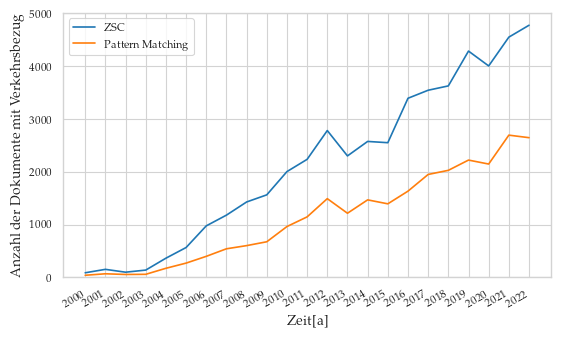

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(6.299212813062128, 3.893127620841233))


plt.style.use('tex.mplstyle')
sns.lineplot(x='jahr' ,y='value', hue='variable', data=pd.melt(df_deberta_ks_per_year, id_vars='jahr'))
fig.autofmt_xdate()
ax.set(xlabel='Zeit[a]', ylabel='Anzahl der Dokumente mit Verkehrsbezug')
ax.set_ylim(bottom=0)

ax.legend_.set_title(None)

fig.savefig('../../latex/Figures/plots/zsc_pm_vergleich_docs_year.pdf', format='pdf', bbox_inches='tight')

In [ ]:
def compare_deberta_keyword_search(kommune):
    fig = px.line(df_deberta_ks[df_deberta_ks['kommune'] == kommune], 
                  x='jahr', 
                  y=['DeBERTa', 'Keyword Search'], 
                  # color='kommune',
                  hover_name="kommune",
                  labels={
                         "jahr": "Zeit (a)",
                         "value": "Anzahl der Dokumente mit Verkehrsbezug",
                         "kommune": "Kommunen",
                         "variable": "Methoden"},
                  # line_shape="spline", 
                  render_mode="svg",
                  template='plotly_white',
                  width=800, 
                  height=400
                 )
    return fig.show()

In [ ]:
compare_deberta_keyword_search('Speyer')

In [ ]:
compare_deberta_keyword_search('Frankenthal')

In [ ]:
compare_deberta_keyword_search('Kreis Bergstraße')

In [ ]:
compare_deberta_keyword_search('Lampertheim')

Notizen:
* Geringere Trefferzahl bei ZSC mit DeBERTa als mit Keyword Search
* Tendenz und Verlauf ist ähnlich

In [ ]:
df_deberta_doc_year_gruppen = df_deberta_doc_year.groupby(['jahr'], as_index=False)[stichwortgruppen].sum()

In [ ]:
kommune = 'Speyer'
fig = px.line(df_deberta_doc_year_gruppen, 
              x='jahr', 
              y=stichwortgruppen,
              # color='kommune',
              # hover_name="kommune",
              labels={
                     "jahr": "Zeit (a)",
                     "value": "Anzahl der Dokumente mit Verkehrsbezug",
                     "kommune": "Kommunen",
                     "variable": "Methoden"},
              # line_shape="spline", 
              render_mode="svg",
              template='plotly_white',
              width=800, 
              height=400
             )
fig.show()

In [92]:
df_deberta_ks_bsp = df_deberta_ks[df_deberta_ks['kommune'].isin(fallbeispiele)]

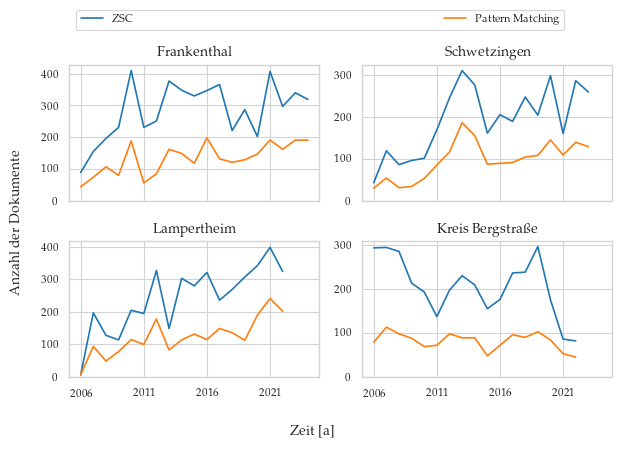

In [93]:
fig, axes = plt.subplots(2, 2, figsize=(6.299212813062128, 4.4), sharex=True)
temp_list = ['jahr'] + stichwortgruppen                  
for fallbeispiel, ax in zip(fallbeispiele, axes.ravel()):
    # filter df for ticker and plot on specified axes
    df_deberta_ks_bsp[df_deberta_ks_bsp["kommune"] == fallbeispiel].plot(x='jahr', ax=ax)

    # chart formatting
    ax.set_title(fallbeispiel, fontsize = 10)
    ax.get_legend().remove()
    ax.set(xlabel=None, ylabel=None)
    ax.set_ylim(bottom=0)

bb = (fig.subplotpars.left, fig.subplotpars.top+0.06, 
      fig.subplotpars.right-fig.subplotpars.left,.1)
# fig.autofmt_xdate()
axes[0][0].legend(bbox_to_anchor=bb, mode="expand", loc="lower left",
               ncol=2, borderaxespad=0., bbox_transform=fig.transFigure)
plt.style.use('tex.mplstyle')
fig.supxlabel('Zeit [a]', fontsize=10)
fig.supylabel('Anzahl der Dokumente', fontsize=10)

fig.tight_layout()
fig.savefig('../../latex/Figures/plots/zsc_pm_vergleich_fallbeispiele.pdf', format='pdf', bbox_inches='tight')

In [ ]:
df_test = pd.read_parquet("data/raw/2023-07-10_gesamtedaten_rhein_neckar.parquet")

In [ ]:
df_deberta_doc['index_doc'] = df_deberta_doc.index

In [ ]:
df = pd.merge(df_test, df_deberta_doc[['index_doc','Gesamt_bool']], on="index_doc")

In [ ]:
df.rename(columns={'Gesamt_bool': 'deberta_verkehr'}, inplace=True)

In [ ]:
df.drop(columns='Gesamt', inplace=True)

In [ ]:
df.to_parquet("data/raw/2023-07-10_gesamtedaten_rhein_neckar2.parquet")